In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
crime = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present.csv")
latitude = crime['Latitude']
longitude = crime['Longitude']
# exclude outskirts with very little datapoints and focus only on downtown
crime = crime[(latitude >= np.mean(latitude) - 3 * np.std(latitude)) & (latitude <= np.mean(latitude) + 3 * np.std(latitude))
             & (longitude >= np.mean(longitude) - 3 * np.std(longitude)) & (longitude <= np.mean(longitude) + 3 * np.std(longitude))]

In [3]:
# number of cases (dataset size)
crime.shape[0]

27298

In [4]:
catData = crime['Incident Category'].value_counts().rename('catCount').to_frame().reset_index()
# 1 and 0 indicate violent and non-violent crime with -1 suggesting crimes with ambiguity such as "other offenses"
# that need excluding
catData['level'] = [0,1,-1,1,1,-1,1,0,0,0,1,0,0,0,0,-1,0,0,-1,-1,1,-1,1,0,0,0,1,1,0,-1,0,1,-1,1,-1,1,1,-1,0,0,1,0,0,-1,1,1]
level = catData['level']
category = catData['index']
def getLevel(a):
    return level[a == category].iloc[0]
crime['level'] = list(map(getLevel, crime['Incident Category']))
crimeFiltered = crime[crime['level'] != -1]

Text(0.5, 1, 'Geographic Distribution of Crimes in Binary Types')

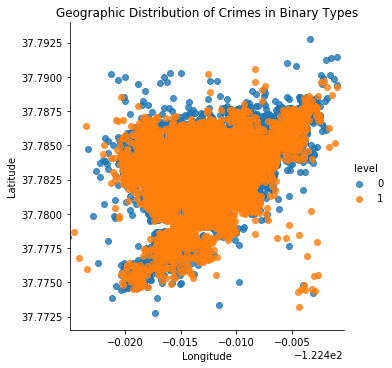

In [5]:
lm = sns.lmplot(x = 'Longitude', y = 'Latitude', hue = 'level', data = crimeFiltered, fit_reg = False,
                x_jitter=0.001, y_jitter=0.001)
plt.xlim(min(crimeFiltered['Longitude']), max(crimeFiltered['Longitude']))
plt.title("Geographic Distribution of Crimes in Binary Types")

In [21]:
from sklearn.model_selection import train_test_split
X = crimeFiltered[['Latitude', 'Longitude']]
y = crimeFiltered['level']
random.seed(2019)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=20)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [23]:
y_pred = classifier.predict(X_test)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1413  739]
 [ 858 1168]]
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      2152
           1       0.61      0.58      0.59      2026

    accuracy                           0.62      4178
   macro avg       0.62      0.62      0.62      4178
weighted avg       0.62      0.62      0.62      4178



In [25]:
predData = pd.DataFrame({
    'Longitude': X_test['Longitude'],
    'Latitude': X_test['Latitude'],
    'y_test': y_test,
    'y_pred': y_pred
})

Text(0.5, 1, 'Predicted Type of y in Test Set')

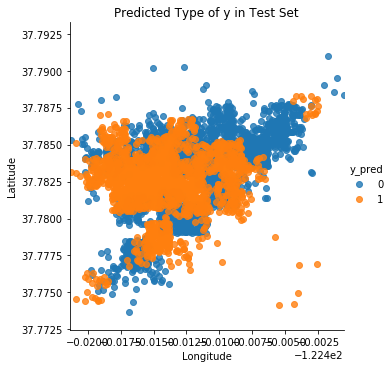

In [26]:
lm = sns.lmplot(x = 'Longitude', y = 'Latitude', hue = 'y_pred', data = predData,fit_reg = False,
                x_jitter=0.001, y_jitter=0.001)
plt.xlim(min(predData['Longitude']), max(predData['Longitude']))
plt.title('Predicted Type of y in Test Set')

Text(0.5, 1, 'Actual Type of y in Test Set')

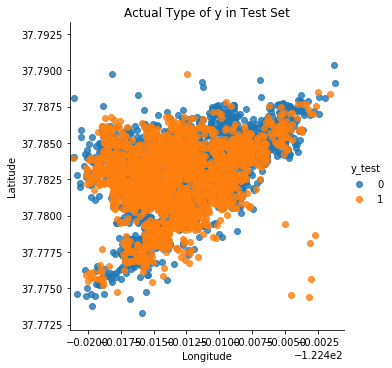

In [27]:
# Because of jitters added to help visualization, the exact location of the data points slightly differ
# between in this plot and above
lm = sns.lmplot(x = 'Longitude', y = 'Latitude', hue = 'y_test', data = predData, fit_reg = False,
                x_jitter=0.001, y_jitter=0.001)
plt.xlim(min(predData['Longitude']), max(predData['Longitude']))
plt.title('Actual Type of y in Test Set')

In [28]:
error = []
# Calculating error for K values between 1 and 50
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

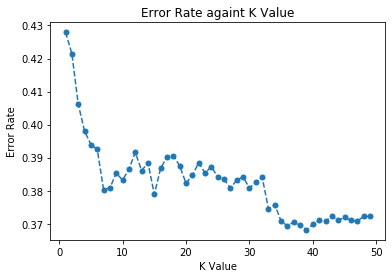

In [29]:
plt.plot(range(1, 50), error,
         linestyle='dashed', 
         marker='.',
         markersize=10)
plt.title('Error Rate againt K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')